In [29]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sympy import *
from tqdm.notebook import tnrange

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

(28, 28)


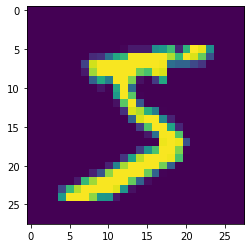

In [31]:
print(x_train[0].shape)
plt.imshow(x_train[0])

In [32]:
x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

# Attempting to Build a NN with Sympy

In [55]:
############################ The Loss Function ############################

''' Compute the Mean Squared Error Between the Input and Model Output '''
def MSE_func():
    y = Symbol('y')
    y_hat = Symbol('\hat{y}')
    
    func = (y - y_hat)**2
    
    return func
    
def eval_MSE(output, label, diff = False):
    func = MSE_func()
    
    y = list(func.free_symbols)[0]
    y_hat = list(func.free_symbols)[1]
    
    if diff == True:
        func = func.diff(y)
        
    # display(func)
    
    f = lambdify((y, y_hat), func)

    return f(output, label)

######################### The Activation Function #########################

def sigmoid_func():
    x = Symbol('x')
    
    sigmoid = 1/(1+exp(-x))
    return sigmoid

def eval_sigmoid(_input_, diff = False):
    func = sigmoid_func()
    x = list(func.free_symbols)[0]
    
    if diff == True:
        func = func.diff(x)
    
    # display(func)
    
    f = lambdify(x, func)
    
    return f(_input_)

######################### The Activation Function #########################
# example of a simple network

def NN(weights, _input_, _label_):

    result = eval_sigmoid(np.dot(weights,_input_), diff = False)

    error = eval_MSE(result, _label_)
    
    return result, error

######################### The Activation Function #########################


def update_weights(weights, _input_, _output_, _label_, epsilon = 1):
    
    grad = eval_sigmoid(np.dot(weights,_input_), diff = True)
    grad = grad*eval_MSE(_output_, _label_, diff = True)
    grad = np.outer(grad,_input_)    

    new_weights = -epsilon*grad
    
    return new_weights

def One_Hot_Encode(labels):
    encoded_labels = np.zeros((len(labels), 10))
    for i in range(len(labels)):
        encoded_labels[i][labels[i]] = 1.
    return encoded_labels
    

# Example Simple Network

In [13]:
num_inputs = 4
num_outputs = 3

_input_ = np.random.rand(num_inputs)
weights = np.zeros((num_outputs,num_inputs))
_label_ = np.ones((num_outputs))

_input_ = np.ones((num_inputs))
_label_ = np.zeros((num_outputs))

output, error = NN(weights, _input_, _label_)
print(output)

[0.5 0.5 0.5]


In [14]:
print(weights)
print(update_weights(weights, _input_, output, _label_, epsilon))

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-0.0025 -0.0025 -0.0025 -0.0025]
 [-0.0025 -0.0025 -0.0025 -0.0025]
 [-0.0025 -0.0025 -0.0025 -0.0025]]


In [20]:
inputs = x_train[0:3000]
labels = y_train[0:3000]
encoded_labels = One_Hot_Encode(labels)

num_inputs = len(inputs[0])
num_outputs = len(encoded_labels[0])

batch_size = 10 # the number of images to look at before making a correction
epsilon = 0.01

weights = np.zeros((num_outputs, num_inputs))

weights_list = []

error_list = []

for i in range(len(inputs)):
    output, error = NN(weights, inputs[i], encoded_labels[i])
        
    # print(np.argmax(output), encoded_labels[i], sum(error))
    weights_list.append(update_weights(weights, inputs[i], output, encoded_labels[i], epsilon))
        
    if (i + 1) % batch_size == 0:
        weights += np.average(weights_list, axis = 0)
        weights_list = []
        error_list.append(sum(error))
        
weights_old = weights

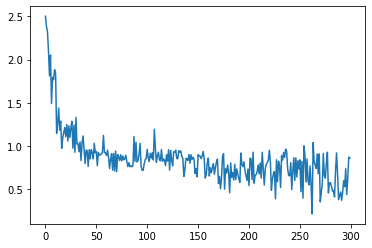

In [21]:
plt.plot(error_list)

In [22]:
inputs = x_test[0:1000]
labels = y_test[0:1000]
encoded_labels = One_Hot_Encode(labels)

num_inputs = len(inputs[0])
num_outputs = len(encoded_labels[0])

num_correct = 0
num_wrong = 0

for i in range(len(inputs)):
    output, error = NN(weights, inputs[i], encoded_labels[i])
              
    if np.argmax(output) == labels[i]:
        num_correct += 1
        
    else:
        num_wrong += 1
print(num_correct/1000)
print(num_wrong/1000)

0.595
0.405


# It would be nice to add a second layer... (maybe 16 nodes?)

In [26]:
def NN(weights, _input_, _label_):

    result = _input_
    layer_outputs = [_input_]
    
    for i in weights:
        result = eval_sigmoid(np.dot(i,result), diff = False)
        layer_outputs.append(result)

    error = eval_MSE(result, _label_)
    
    return layer_outputs, error





def initialize_weights(node_sequence):
    layers = np.flip(node_sequence.repeat(2)[1:-1].reshape(len(node_sequence)-1,2), axis = 1)
    
    weights = []
    weights_list = {}
    for i in range(len(layers)):
        weights.append(np.zeros(layers[i]))
        weights_list[i] = np.array([weights[i]]) # just a temporary zero array
        
    return weights, weights_list


# must be able to handle several errors!
def update_weights(weights, layer_outputs, _label_, epsilon = 1):
    
    # print(layer_outputs)
    new_weights = weights.copy()
    
    MSE = eval_MSE(layer_outputs[-1], _label_, diff = True) # first calc derivitive of MSE
    # print('MSE:', MSE)
    
    for i in range(len(weights), 0, -1): # work backwards
                
        grad = eval_sigmoid(np.dot(weights[i-1],layer_outputs[i-1]), diff = True) # derivitive of sigmoid
        # print('current weight:', weights[i-1])
        # print('grad:', grad)
        
        
        
        for j in range(len(weights), i, -1): # this is for chain rule (skips last layer since no chain rule there)
            if j == len(weights):
                new_grad = np.dot(eval_sigmoid(np.dot(weights[j-1],layer_outputs[j-1]), diff = True) * MSE, weights[j-1])
                
            else:
                new_grad = np.dot(eval_sigmoid(np.dot(weights[j-1],layer_outputs[j-1]), diff = True), weights[j-1])
                
            # print('new grad:', new_grad)
            
            
            grad *= new_grad
            
            
        if len(weights) == 1:
            grad = grad*MSE
            
        grad = np.outer(grad,layer_outputs[i-1]) 
        
        new_weights[i-1] = epsilon*grad
        
    return new_weights, weights

In [27]:
num_inputs = 4
num_outputs = 3
node_sequence = np.array([num_inputs, 5, num_outputs])

_input_ = np.ones((num_inputs))
_label_ = np.zeros((num_outputs))

weights, weights_list = initialize_weights(node_sequence)


layer_outputs, error = NN(weights, _input_, _label_)
print(error)

[0.25 0.25 0.25]


In [28]:
epsilon = 0.01
new_weights, weights = update_weights(weights, layer_outputs, _label_, epsilon)
print(weights)
print(new_weights)

[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])]
[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[0.00125, 0.00125, 0.00125, 0.00125, 0.00125],
       [0.00125, 0.00125, 0.00125, 0.00125, 0.00125],
       [0.00125, 0.00125, 0.00125, 0.00125, 0.00125]])]


In [10]:
inputs = x_train[0:1000]
labels = y_train[0:1000]
encoded_labels = One_Hot_Encode(labels)


num_inputs = len(inputs[0])
num_outputs = len(encoded_labels[0])


node_sequence = np.array([num_inputs, num_outputs])

weights, weights_list = initialize_weights(node_sequence)

batch_size = 10 # the number of images to look at before making a correction
epsilon = 0.01

error_list = []

for i in range(len(inputs)):
            
    layer_outputs, error = NN(weights, inputs[i], encoded_labels[i])

    
    new_weights, weights = update_weights(weights, layer_outputs, encoded_labels[i], epsilon)
    
    for j in range(len(weights)):
        weights_list[j] = np.concatenate((weights_list[j], [new_weights[j]])) 
       
    
    if len(weights_list[0]) % batch_size == 0:
        for j in range(len(weights)):

            weights[j] -= np.average(weights_list[j], axis = 0)
            weights_list[j] = [np.copy(weights[j])]
            
        error_list.append(sum(error))
            
weights_new = weights

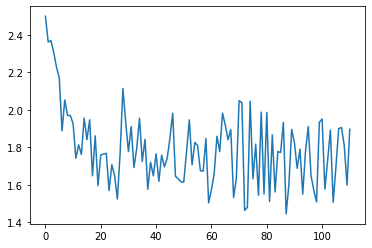

In [11]:
plt.plot(error_list[:])

In [1003]:
inputs = x_test[0:1000]
labels = y_test[0:1000]
encoded_labels = One_Hot_Encode(labels)

num_inputs = len(inputs[0])
num_outputs = len(encoded_labels[0])


num_correct = 0
num_wrong = 0

for i in range(len(inputs)):
    layer_outputs, error = NN(weights, inputs[i], encoded_labels[i])
    
    if np.argmax(layer_outputs[-1]) == labels[i]:
        num_correct += 1

    else:
        num_wrong += 1
    
print(num_correct/1000)
print(num_wrong/1000)

0.277
0.723


In [664]:
a = [[[1,2,3,4], [5,6,7,8]], [[1,2,3,4], [5,6,7,8]]]
np.average(a, axis = 0)

array([[1., 2., 3., 4.],
       [5., 6., 7., 8.]])

In [973]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
a + b

array([[ 6,  8],
       [10, 12]])

In [928]:
for h in range(1,0,-1):
    print(h)

1
